Exercise12

In [8]:
import pandas as pd

data = pd.read_csv("air_pollution_dataframe.csv")

data = data.fillna(0)
data = data.apply(pd.to_numeric, errors='coerce')
data.rename(columns={"Timestamp": "tid"}, inplace=True)
data["tid"] = range(1, len(data) + 1)
data.to_csv("output.csv", index=False)
print(data)

     tid  Point(sensorID_01101010)  Point(sensorID_01101020)   
0      1                       0.0                       0.0  \
1      2                       0.0                       0.0   
2      3                       0.0                       0.0   
3      4                       0.0                       0.0   
4      5                       0.0                       0.0   
..   ...                       ...                       ...   
739  740                       0.0                       0.0   
740  741                       0.0                       0.0   
741  742                       0.0                       0.0   
742  743                       0.0                       0.0   
743  744                       0.0                       0.0   

     Point(sensorID_01101520)  Point(sensorID_01101540)   
0                        10.0                       6.0  \
1                         7.0                       5.0   
2                         5.0                       4.

transactional_database.py

In [14]:
from PAMI.extras.DF2DB import denseDF2DB as pro 
import pandas as pd

data = pd.read_csv('output.csv')

df = pd.DataFrame(data)
df.fillna(0, inplace=True)

db = pro.denseDF2DB(inputDF=df, thresholdValue=15, condition='>=')

db.createTransactional(outputFile='PM24HeavyPollutionRecordingSensors.csv')

FP-growth algorithm

In [71]:
from PAMI.frequentPattern.basic import FPGrowth as alg

inputFile = 'PM24HeavyPollutionRecordingSensors.csv'

minSup=200

obj = alg.FPGrowth(inputFile, minSup)

obj.startMine()

print("Total number of Frequent Patterns:", len(obj.getPatterns()))

output_file = 'frequentPatterns.txt'
obj.save(output_file)

print("Total Memory in RSS", obj.getMemoryRSS())

print("Total ExecutionTime in seconds:", obj.getRuntime())

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total number of Frequent Patterns: 970
Total Memory in RSS 1339351040
Total ExecutionTime in seconds: 0.8437511920928955


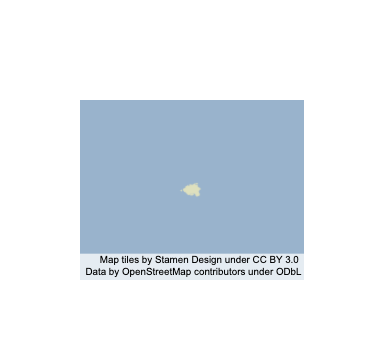

In [73]:
import re
import plotly.graph_objects as go

data_dict = {}

with open('frequentPatterns.txt', 'r') as file:
    current_sensor_id = None
    for line in file:
        line = line.strip()
        if not line:
            continue  

        sensor_id_match = re.search(r'sensorID_(\d+)', line)
        if sensor_id_match:
            sensor_id = sensor_id_match.group(1)
        else:
            continue

        tid_match = re.search(r'tid:(\d+)', line)
        if tid_match:
            tid = tid_match.group(1)
        else:
            continue

        if sensor_id in data_dict:
            data_dict[sensor_id].append(tid)
        else:
            data_dict[sensor_id] = [tid]

longest_pattern = max(data_dict, key=lambda x: len(data_dict[x]), default=None)

if longest_pattern is not None:

    lats = []
    lons = []
    for sensor_id in longest_pattern:
        parts = sensor_id.split('_')
        if len(parts) == 2: 
            lat_lon = parts[1]
        elif len(parts) == 3:
            lat_lon = parts[1] + '_' + parts[2]
        else:
            continue

        lat, lon = lat_lon.split(':')
        lats.append(float(lat) / 1000000) 
        lons.append(float(lon) / 1000000) 

    fig = go.Figure()
    fig.add_trace(go.Scattermapbox(
        mode="markers+lines",
        lon=lons,
        lat=lats,
        marker={'size': 10},
        line=dict(width=2, color='blue')
    ))

    fig.update_layout(
        mapbox={
            'style': "stamen-terrain",
            'center': {'lon': sum(lons) / len(lons), 'lat': sum(lats) / len(lats)} if len(lats) > 0 and len(lons) > 0 else None,
            'zoom': 14
        },
        showlegend=False
    )

    fig.show()
